# MAMBO deep learning inference

# Overview

* Install and run a model that should extract shrub outlines from imagery
* Deeper dive into what's happening and hwo to bring your own data
* A look at _explainability_ tools that show us what the model is seeing
* Using the output as input for height estimation from surface data

## Setup

This will be much faster with a `GPU runtime`. At the top of this page, select `Runtime` ... `Change runtime type` ... `T4 GPU`.

The workshop will save all the output data to the machine that hosts its notebook, which will disappear after it's shut down! You might want to save copies inside Google Drive - connect to it like this, and approve the pop-up windows.



Next, install the packages we need - the Attention Unet model, and functions for handling the GeoTIFF data and exporting polygons.

The installation will take a few minutes to run; if you restart the notebook it will recognise what's already been installed.

In [ ]:
%pip install git+https://github.com/MAMBO-Horizon-WP4/att-unet-shrub-id.git

In [ ]:
import os
import shutil
import io
import s3fs
import shrubnet
from shrubnet.model import AttentionUNet
from shrubnet.dataset import RSDataset
from shrubnet.inference import run_inference
from shrubnet.train import train_model
import torch
from torchvision.transforms.functional import to_tensor
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image, reshape_as_raster


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.makedirs('/content/drive/MyDrive/MAMBO', exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Set these environment variables that show which cloud-based storage to connect to.

In our example, the data is hosted at [JASMIN object store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)

Data hosted in the [AWS s3 store](https://aws.amazon.com/s3/) could be read in exactly the same way.

In [ ]:
os.environ['AWS_S3_ENDPOINT'] = 'address_without_https'
os.environ['AWS_ENDPOINT_URL'] = 'address_with_https'
os.environ['AWS_VIRTUAL_HOSTING']="False"
os.environ['AWS_HTTPS']="True"
os.environ['AWS_NO_SIGN_REQUEST'] = "True"
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

s3 = s3fs.S3FileSystem(anon=True)

## Load a pre-trained model

Our _model weights_ are also kept in object storage. This is a pre-trained model used for shrub detection from 3 band RGB imagery.

First we define our model:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionUNet().to(device)

And then read the weights from object storage, and load them into the model.

If you had a local file with the weights, this would look like

`model.load_state_dict(torch.load("best_model.pth"))`


_TODO_ - option to load model state from GDrive, if we've run the previous notebook_

In [ ]:
model_state = "s3://attn-unet-shrub-id/model/best_model.pth"

with s3.open(model_state) as state:
    buffer = io.BytesIO(state.read())
    model.load_state_dict(torch.load(buffer))

model.eval()


## Step by step through inference

We hand an image to the model, and it returns its estimate of how likely each pixel is to be part of a shrub, or not. We'll go through these steps:

* Read an area of the image
* Normalise the pixel values to a range of 0 - 1
* Turn the image into a `tensor` and put it on the GPU
* Give the tensor to the model, and it returns a set of predictions

In [ ]:
window = Window(256, 256, 256, 256)
with rasterio.open("s3://attn-unet-shrub-id/data/test/test_area.tif") as src:
    data = src.read(window=window)

In [ ]:
data = data / 255

We use the convenient [reshape_as_image](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.reshape_as_image) function provded by `rasterio` to swap the axes order from (bands, rows, columns) - the TIFF format - to (rows, columns, bands) - what the model expects.

`unsqueeze` here adds an extra dimension - the model accepts a batch of images, here we're telling it that it's a batch of one.

`to` is copying the image data onto the GPU

In [ ]:
window_tensor = to_tensor(reshape_as_image(data)).unsqueeze(0).float().to(torch.device('cuda'))

In [ ]:
with torch.no_grad():
    output = model(window_tensor).float().cpu().numpy().squeeze(axis=1)

The result is a list of list of predictions, each one corresponding to a pixel location:

In [ ]:
output.shape

(1, 256, 256)

The values aren't exactly probabilities, but we can interpret them as a kind of heatmap of shrub likeliness

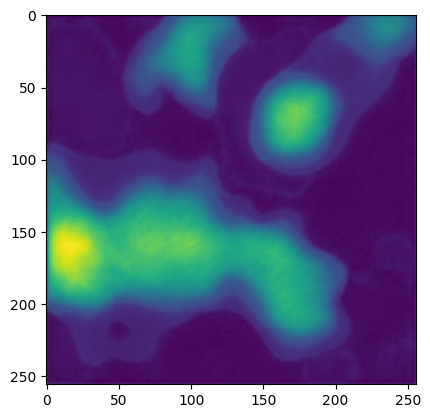

<Axes: >

In [ ]:
show(reshape_as_raster(output))

The threshold value of 0.5 offers a much harder edge to our shrub predictions

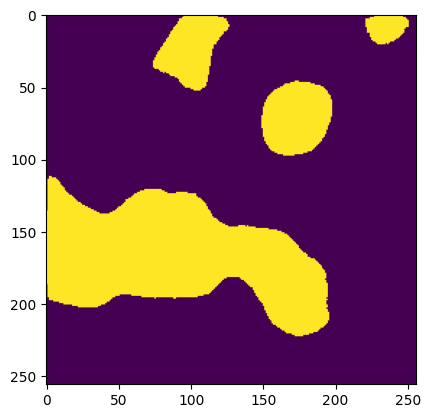

<Axes: >

In [ ]:
show(reshape_as_raster(output > 1))

We can use the `run_inference` function pass a single large image to the model.

This breaks it up into small windows with dimensions of `window_size` and with overlaps of `step_size` (so that shrubs that sit on the edge of a window are not easily missed)

 ```
    model,
    input_image_path,
    output_image_path,
    window_size=(512, 512),
    step_size=(256, 256),
    threshold=0.5,
    device="cuda"
```

Let's start this running, and then we'll look at the detail.

We've got a large test image in object storage. We can use its `s3` URL in the same way as we can use the path to a file.

Our test image is 6773 x 14419 pixels in size!

We could use the `run_inference` function to load the image directly from cloud storage and process it all at once, but it would take too long for this tutorial.


In [ ]:
#run_inference(model, 's3://attn-unet-shrub-id/data/test/test_area.tif', 'test_out.tif')

Let's read a small window from the image and make predictions from that:

In [ ]:
window = Window(0, 0, 768, 768)
with rasterio.open("s3://attn-unet-shrub-id/data/test/test_area.tif") as src:
    kwargs = src.meta.copy()
    kwargs.update(
                    {
                        "height": window.height,
                        "width": window.width,
                        "transform": rasterio.windows.transform(window, src.transform),
                    })
    with rasterio.open('test_input.tif', "w", **kwargs) as dst:
        dst.write(src.read(window=window))


Let's have a quick look at it:

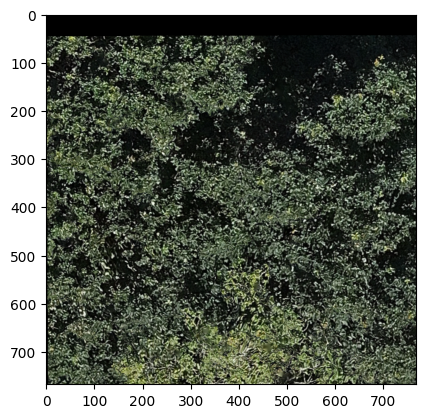

<Axes: >

In [ ]:
with rasterio.open('test_input.tif') as src:
    data=src.read()

show(data)

Use our test sample to create a binary mask which shows shrub / non-shrub areas

In [ ]:
run_inference(model, 'test_input.tif', 'test_mask.tif')


In [ ]:
with rasterio.open('test_input.tif') as src:
    data=src.read()

show(data)

Option to save a copy in Google Drive at any time, like this:

In [ ]:
shutil.copy('test_out.tif', '/content/drive/MyDrive/MAMBO/test_out.tif')

'/content/drive/MyDrive/MAMBO/test_out.tif'

_TODO: use `captum` to do some visual explanations_